In [1]:
import xarray as xr
import random
import datetime

In [42]:
ds = xr.open_zarr("/Net/Groups/BGI/work_1/scratch/fluxcom/upscaling_inputs/MODIS_VI_perRegion061/EVI/Groups_EVIgapfilled_QCdyn.zarr")

/tmp/ipykernel_2731504/3789137383.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr("/Net/Groups/BGI/work_1/scratch/fluxcom/upscaling_inputs/MODIS_VI_perRegion061/EVI/Groups_EVIgapfilled_QCdyn.zarr")


In [43]:
ds_vi = ds.EVIgapfilled_QCdyn#.stack({'lat':['latchunk','latstep_modis'], 'lon':['lonchunk','lonstep_modis']})
# Load the dataset
#lat_indices = random.choices(ds_vi.lat.values, k=3000)
#lon_indices = random.choices(ds_vi.lon.values, k=3000)
#ds_vi.isel(time=1).values

(array([3.0900000e+02, 1.4270000e+03, 1.4253637e+07, 1.6617208e+07,
        4.3680760e+06, 1.7998000e+04, 5.1000000e+01, 5.8000000e+01,
        7.1000000e+01, 1.6200000e+02]),
 array([-0.76004606, -0.45912984, -0.15821362,  0.14270261,  0.44361883,
         0.74453509,  1.04545128,  1.34636748,  1.64728379,  1.94819999,
         2.24911618]),
 <BarContainer object of 10 artists>)

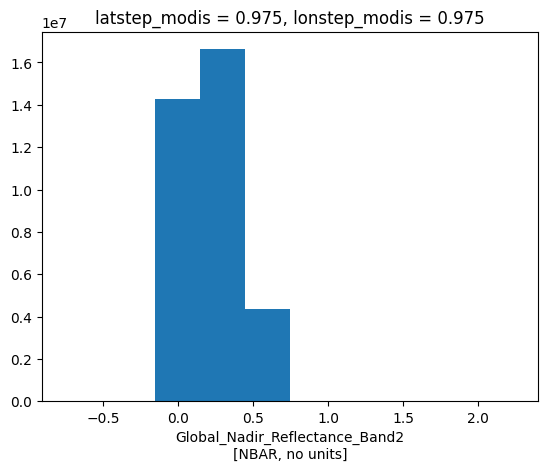

In [46]:
ds_vi.sel(latstep_modis=50.0, lonstep_modis=11, method='nearest').plot()

In [4]:
#select a location 
ds = xr.open_zarr("/Net/Groups/BGI/scratch/mweynants/DeepExtremes/v3/PEICube.zarr")

# Transform the longitude coordinates to -180 and 180
def coordstolongitude(x):
       return ((x + 180) % 360) - 180
dsc = ds.roll(longitude = 180*4, roll_coords=True)
ds_pei = dsc.assign_coords(longitude = coordstolongitude(dsc.longitude))
# Remove the year 1950 because the data are inconsistent
ds_pei = ds_pei.sel(time=slice(datetime.date(1951,1,1), datetime.date(2022,12,31)))

lat_indices = random.choices(ds_pei.latitude.values, k=1000)
lon_indices = random.choices(ds_pei.longitude.values, k=1000)
pei = ds_pei.sel(latitude=lat_indices[500], longitude=lon_indices[500], time=slice(datetime.date(1951,1,1), datetime.date(2022,12,31))).pei_180

# plot the seasonality
pei.groupby("time.dayofyear").mean("time").plot()
pei.chunk(dict(time=-1)).groupby("time.dayofyear").quantile(q=0.05, dim="time").plot()
pei.chunk(dict(time=-1)).groupby("time.dayofyear").quantile(q=0.95, dim="time").plot()
pei.groupby("time.dayofyear").min("time").plot()
pei.groupby("time.dayofyear").max("time").plot()


KeyboardInterrupt: 

In [3]:
# Load the PEI-* drought indices
ds = xr.open_zarr("/Net/Groups/BGI/scratch/mweynants/DeepExtremes/v3/PEICube.zarr")

# Transform the longitude coordinates to -180 and 180
def coordstolongitude(x):
       return ((x + 180) % 360) - 180
dsc = ds.roll(longitude = 180*4, roll_coords=True)
ds_pei = dsc.assign_coords(longitude = coordstolongitude(dsc.longitude))
# Remove the year 1950 because the data are inconsistent
ds_pei = ds_pei.sel(time=slice(datetime.date(1951,1,1), datetime.date(2022,12,31)))

# Stack the longitude and latitude dimensions into a new dimension called lonlat
ds_pei = ds_pei.stack(lonlat=("longitude", "latitude")).transpose(
            "lonlat", "time", ...
        )

# Remove the year 1950 because the data are inconsistent
ds_pei = ds_pei.sel(
            time=slice(datetime.date(1951, 1, 1), datetime.date(2022, 12, 31))
        )

# Select k locations randomly to train the PCA:
lat_indices = random.choices(ds_pei.latitude.values, k=10)
lon_indices = random.choices(ds_pei.longitude.values, k=10)
ds_pei = ds_pei.sel(latitude=lat_indices, longitude=lon_indices)

# Stack the longitude and latitude dimensions into a new dimension called lonlat
ds_pei = ds_pei.stack(lonlat=('longitude', 'latitude')).transpose('lonlat', 'time', ...)

# compute the MSC
for pei_indice in ['pei_30', 'pei_90', 'pei_180']:
    ds_pei[f'msc_{pei_indice}'] = ds_pei[pei_indice].groupby("time.dayofyear").mean("time")

In [2]:
# Load the PEI-* drought indices
ds = xr.open_zarr("/Net/Groups/BGI/scratch/mweynants/DeepExtremes/v3/PEICube.zarr", )


In [2]:
# Load the PEI-* drought indices
ds = xr.open_zarr("/Net/Groups/BGI/scratch/mweynants/DeepExtremes/v3/PEICube.zarr", )

# Transform the longitude coordinates to -180 and 180
def coordstolongitude(x):
       return ((x + 180) % 360) - 180
dsc = ds.roll(longitude = 180*4, roll_coords=True)
#ds_pei = dsc.assign_coords(longitude = coordstolongitude(dsc.longitude))
# Remove the year 1950 because the data are inconsistent
# ds_pei = ds_pei.sel(time=slice(datetime.date(1951,1,1), datetime.date(2022,12,31)))

# Stack the longitude and latitude dimensions into a new dimension called lonlat
#ds_pei = ds_pei.stack(lonlat=("longitude", "latitude")).transpose(
#            "lonlat", "time", ...
#        )
# ds_pei

In [18]:
for i in ds_pei.data_vars:
    print(i)

pei_180
pei_30
pei_90
msc_pei_30
msc_pei_90
msc_pei_180


PCA(n_components=10)

In [88]:
pca.explained_variance_ratio_[:5]

array([0.63044574, 0.28205099, 0.03906764, 0.02449689, 0.01613243])

<BarContainer object of 73 artists>

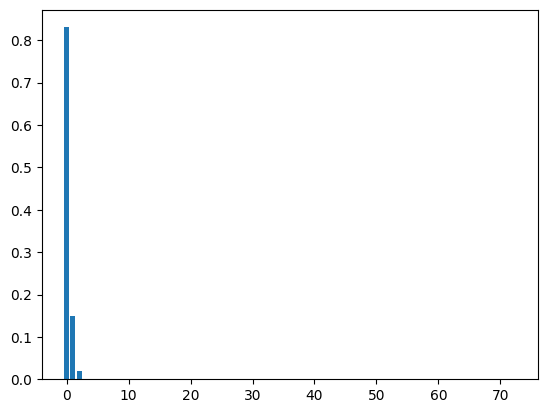

In [63]:
import matplotlib.pyplot as plt
plt.bar(range(n_components), pca.explained_variance_ratio_)

In [ ]:
# Add the project root to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))

# from regional_extremes import CLIMATIC_FILEPATH
CLIMATIC_FILEPATH = "/Net/Groups/BGI/scratch/mweynants/DeepExtremes/v3/PEICube.zarr"
from regional_extremes import RegionalExtremes, ClimaticRegionalExtremes